In [1]:
from data import Data
from dimension_reduction import PCADimensionReduction
from simple_ml_models import *
from utils import *
from additional_test_set_visualisation import Visualisation

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import svm
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


2023-01-07 23:37:10.459040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_filepath = "data/by_type/t2/counts_ctc_simulated_123_5k_t2.tsv"
true_results_filepath = "data/by_type/t2/ids_ctc_simulated_123_5k_t2.tsv"
train_indices_filepath = "data/by_type/t2/train_indices.npy"
test_indices_filepath = "data/by_type/t2/test_indices.npy"
SEED = 42
FOLD_NUMBER = 3



# There are 4 data variants to check: regular, scaled, cut by max, pca reduced + cut by max
data_object = Data(data_filepath, true_results_filepath)
train_data, test_data, train_true_results, test_true_results =  data_object.load_train_test_split(train_indices_filepath, test_indices_filepath)

In [3]:
cut_by_mean_with_classes_train_data, cut_by_mean_with_classes_test_data = data_object.cut_data_by_mean_with_classes(data_object.train_data, data_object.test_data, 0.5)

In [4]:
cut_by_mean_train_data, cut_by_mean_test_data = Data.cut_data_by_mean(
    data_object.train_data, data_object.test_data, threshold=0.3
)
(
    cut_by_mean_max_train_data,
    cut_by_mean_max_test_data,
) = Data.cut_data_by_max(
    cut_by_mean_train_data, cut_by_mean_test_data, threshold=3
)

### LightGBM

In [5]:
lgbm_clf = LGBMClassifier(
    boosting_type="gbdt",
    min_child_weight=0.01,
    max_depth=10,
    num_leaves=16,
    n_estimators=2000,
    subsample_for_bin=10000,
    is_unbalance=True,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [6]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()


Validation balanced accuracy 0.941919191919192
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.883838383838384
Training recall 1.0

Validation f1 0.9363636363636364
Training f1 1.0



In [7]:
lgbm_model_object.display_test_results()


Test balanced accuracy 0.9555555555555556

Test roc auc 0.9999488360194423

Test precision 1.0

Test recall 0.9111111111111111

Test f1 score 0.9514687100893998


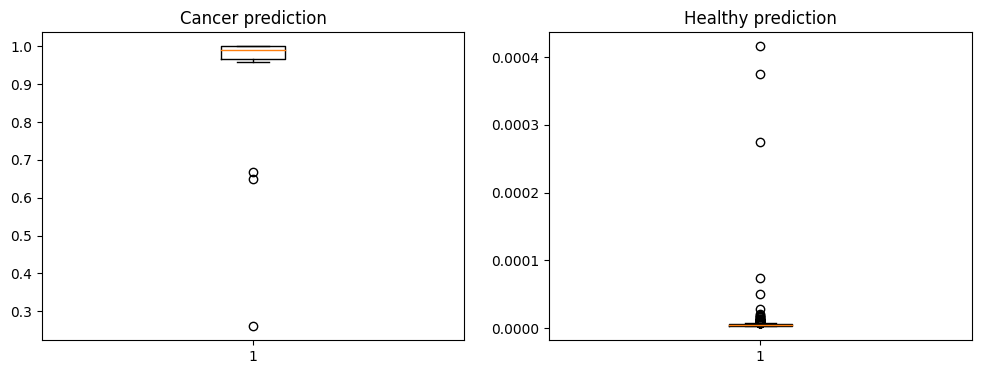

In [8]:
vis = Visualisation(lgbm_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

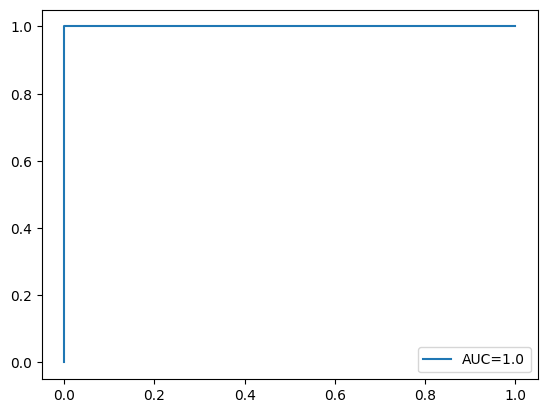

In [9]:
vis.draw_roc_curve_from_probabilities()

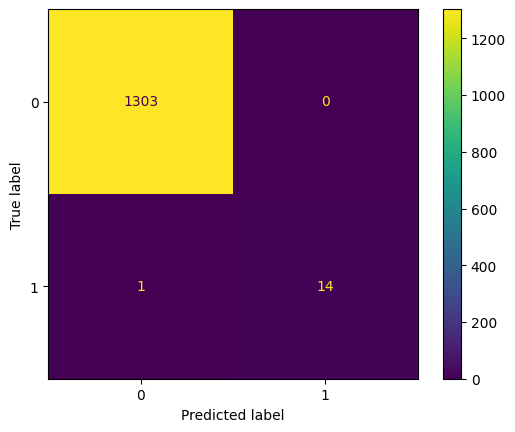

In [10]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [11]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.9291284014877302
Training balanced accuracy 1.0

Validation roc auc 0.9997208013002683
Training roc auc 1.0

Validation precision 0.9696969696969697
Training precision 1.0

Validation recall 0.8585858585858586
Training recall 1.0

Validation f1 0.9090909090909091
Training f1 1.0



In [12]:
lgbm_model_object.display_test_results()

Test balanced accuracy 0.933205423381939

Test roc auc 0.9999317813592564

Test precision 0.9777777777777779

Test recall 0.8666666666666667

Test f1 score 0.9111111111111111


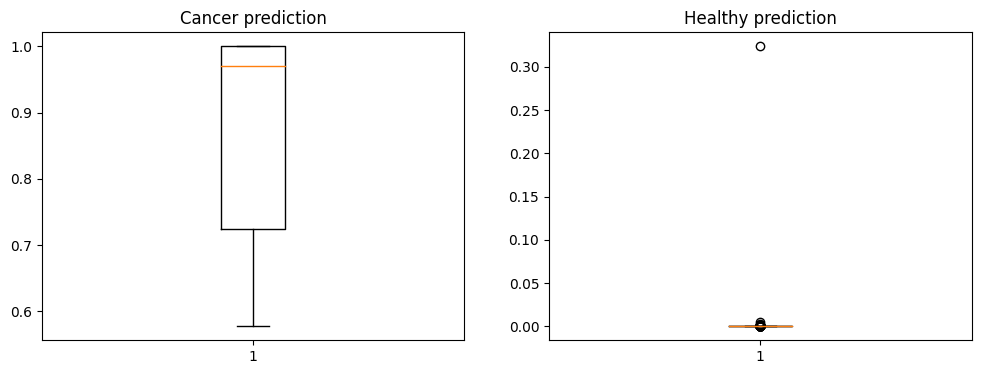

In [13]:
vis = Visualisation(lgbm_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

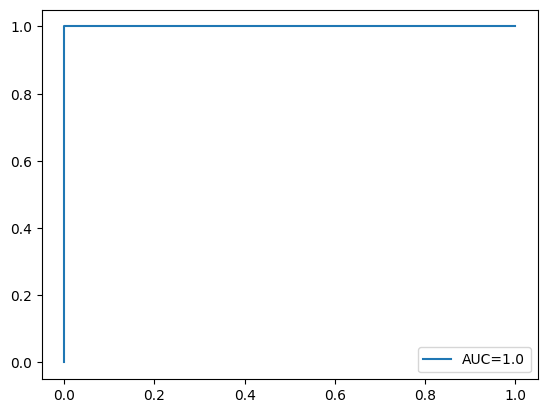

In [14]:
vis.draw_roc_curve_from_probabilities()

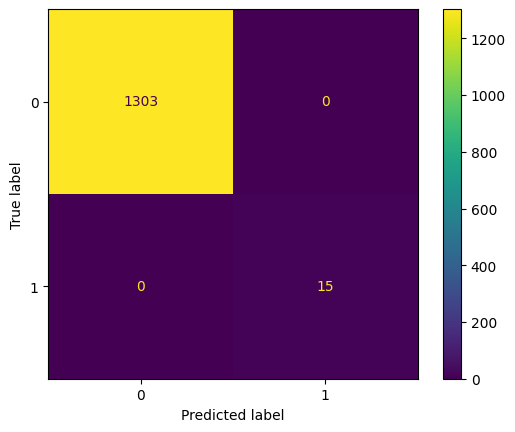

In [15]:
vis.display_confusion_matrix()

### XGBoost

In [16]:
healthy_cells_train_indices = np.where(data_object.train_true_results == 0)[0]
cancer_cells_train_indices = np.where(data_object.train_true_results == 1)[0]

class_weight = len(healthy_cells_train_indices) / len(cancer_cells_train_indices)

xgb_clf = XGBClassifier(
    booster="gbtree",
    eta=0.2,
    min_child_weight=48,
    max_depth=8,
    gamma=0.01,   
    scale_pos_weight=class_weight,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [17]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9558080808080808
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.9116161616161617
Training recall 1.0

Validation f1 0.9521739130434783
Training f1 1.0



In [18]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.9777777777777779

Test roc auc 1.0

Test precision 1.0

Test recall 0.9555555555555556

Test f1 score 0.9770114942528737


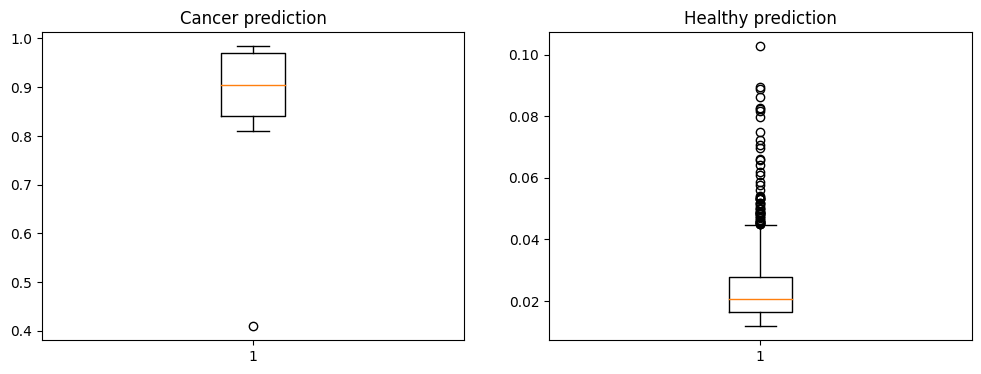

In [19]:
vis = Visualisation(xgboost_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

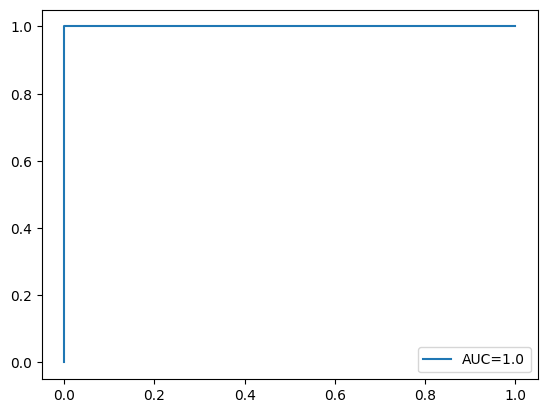

In [20]:
vis.draw_roc_curve_from_probabilities()

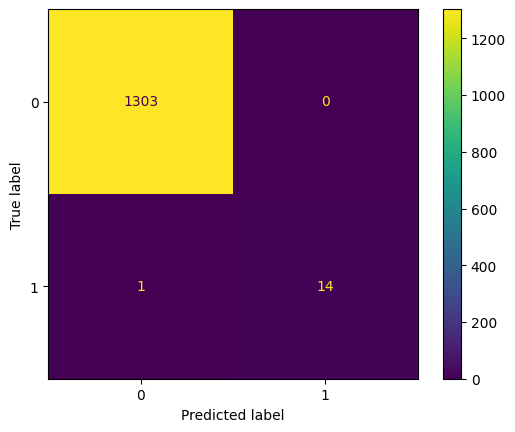

In [21]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [22]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 1.0
Training balanced accuracy 0.9999177360974004

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 0.9861111111111112

Validation recall 1.0
Training recall 1.0

Validation f1 1.0
Training f1 0.9929078014184397



In [23]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.9886330689861005

Test roc auc 0.999522469514795

Test precision 0.9583333333333334

Test recall 0.9777777777777779

Test f1 score 0.967741935483871


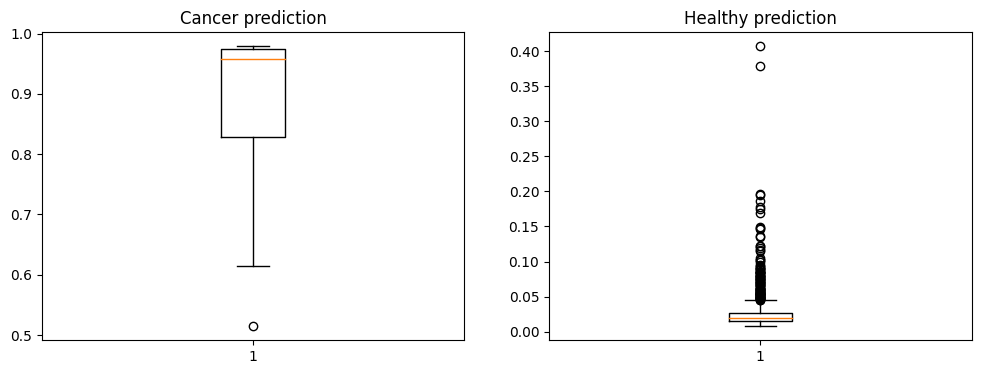

In [24]:
vis = Visualisation(xgboost_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

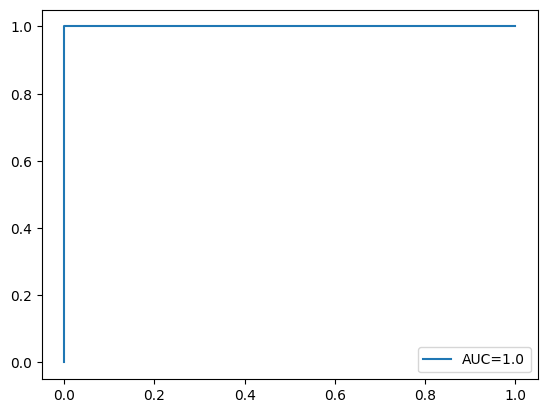

In [25]:
vis.draw_roc_curve_from_probabilities()

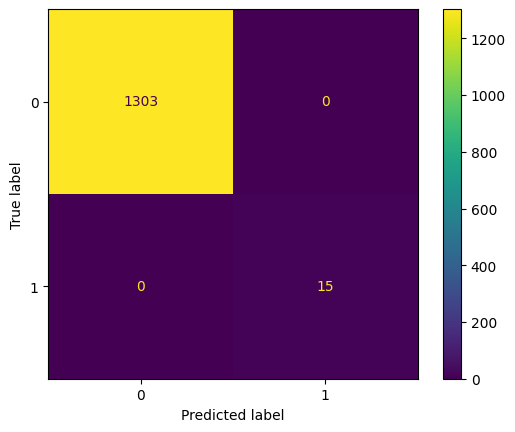

In [26]:
vis.display_confusion_matrix()

### Random Forest

In [27]:
rf_clf = RandomForestClassifier(  
    criterion="log_loss",
    n_estimators=2000,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [28]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 1.0
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 1.0
Training recall 1.0

Validation f1 1.0
Training f1 1.0



In [29]:
rf_model_object.display_test_results()

Test balanced accuracy 0.9666666666666667

Test roc auc 1.0

Test precision 1.0

Test recall 0.9333333333333332

Test f1 score 0.9655172413793104


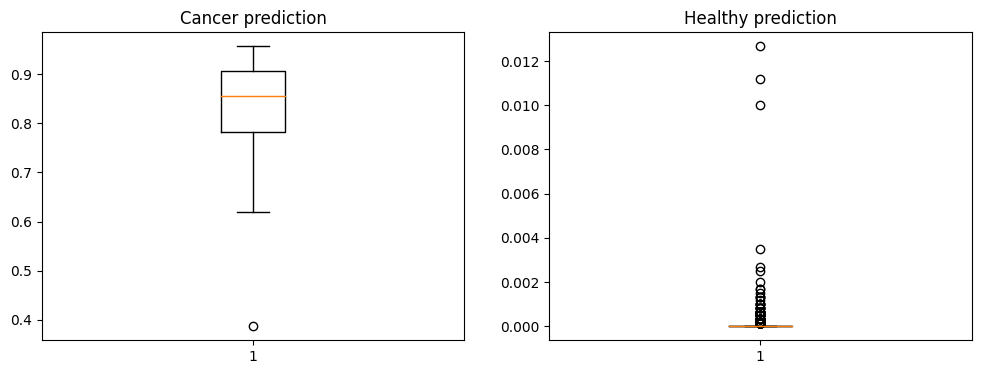

In [30]:
vis = Visualisation(rf_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

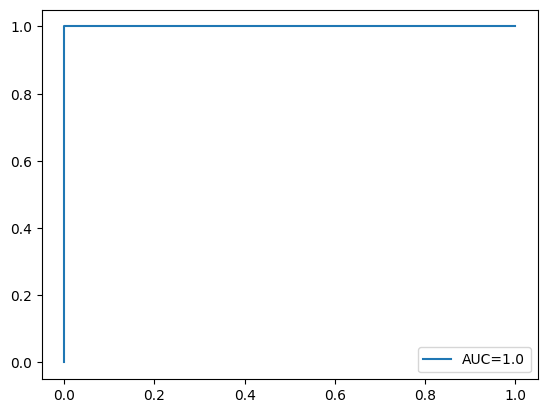

In [31]:
vis.draw_roc_curve_from_probabilities()

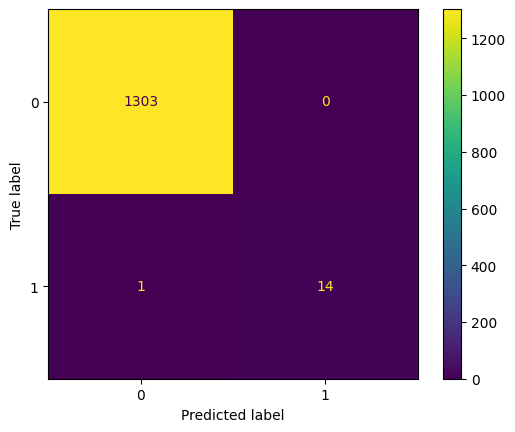

In [32]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [33]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9558080808080808
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.9116161616161617
Training recall 1.0

Validation f1 0.9521739130434783
Training f1 1.0



In [34]:
rf_model_object.display_test_results()

Test balanced accuracy 0.9333333333333332

Test roc auc 1.0

Test precision 1.0

Test recall 0.8666666666666667

Test f1 score 0.9276591862798759


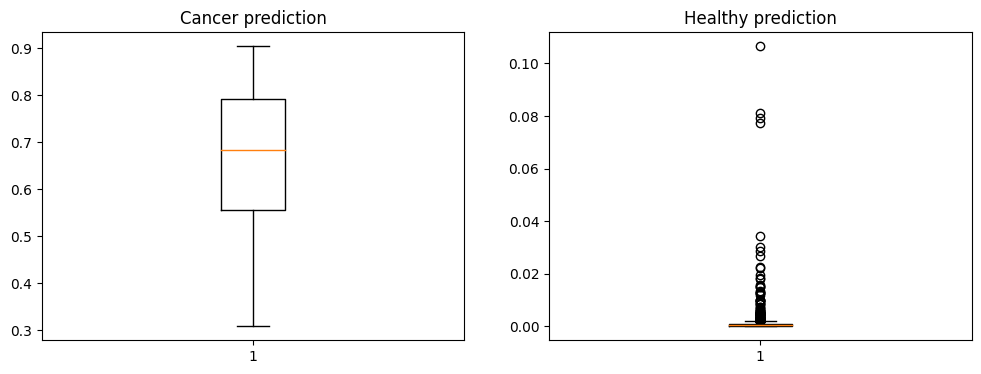

In [35]:
vis = Visualisation(rf_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

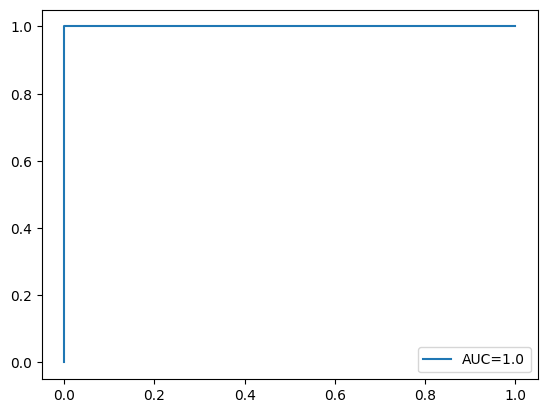

In [36]:
vis.draw_roc_curve_from_probabilities()

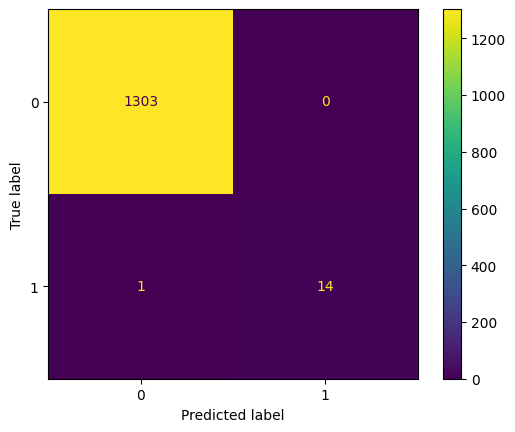

In [37]:
vis.display_confusion_matrix()

### Balanced Random Forest

In [38]:
brf_clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    class_weight="balanced",
    criterion="entropy",
    oob_score=True,  
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [39]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 1.0
Training balanced accuracy 0.999835472194801

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 0.9722222222222223

Validation recall 1.0
Training recall 1.0

Validation f1 1.0
Training f1 0.9858156028368793



In [40]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9996162701458173

Test roc auc 1.0

Test precision 0.9375

Test recall 1.0

Test f1 score 0.967741935483871


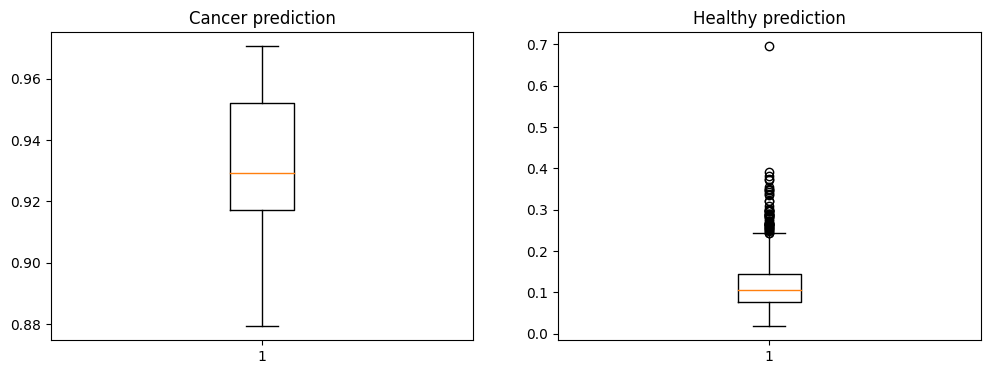

In [41]:
vis = Visualisation(brf_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

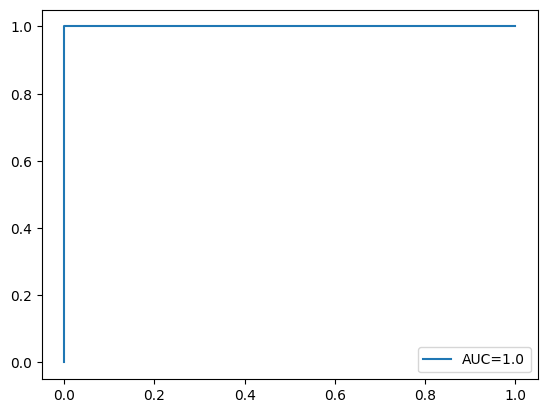

In [42]:
vis.draw_roc_curve_from_probabilities()

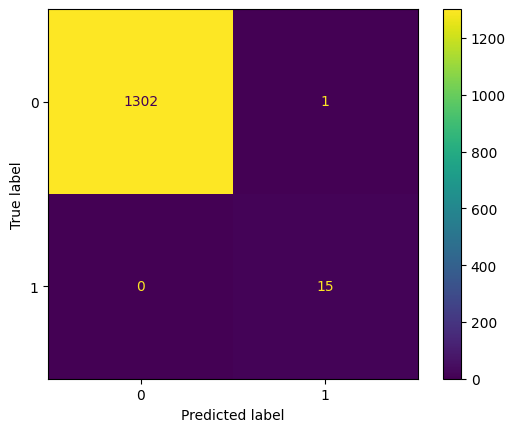

In [43]:
vis.display_confusion_matrix()

### Cut by mean with classes

In [44]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9995064165844028
Training balanced accuracy 0.9993418887792037

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 0.9209401709401709
Training precision 0.8988224121557454

Validation recall 1.0
Training recall 1.0

Validation f1 0.958840579710145
Training f1 0.9461224489795917



In [45]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9992325402916347

Test roc auc 1.0

Test precision 0.8843954248366014

Test recall 1.0

Test f1 score 0.9381109481915934


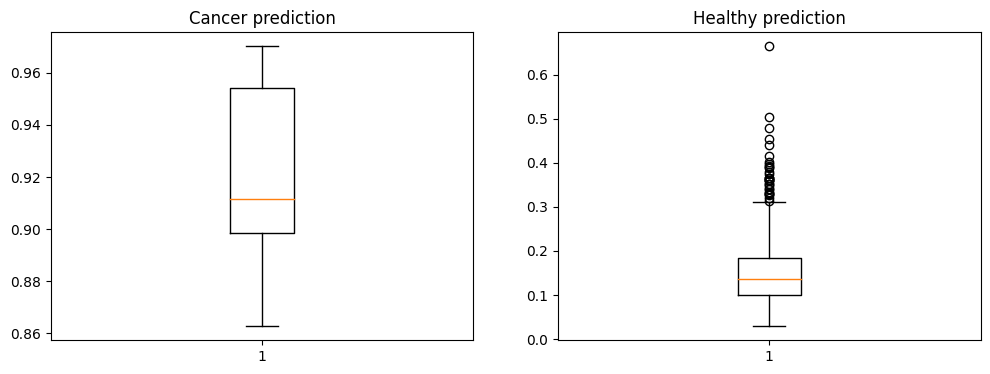

In [46]:
vis = Visualisation(brf_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

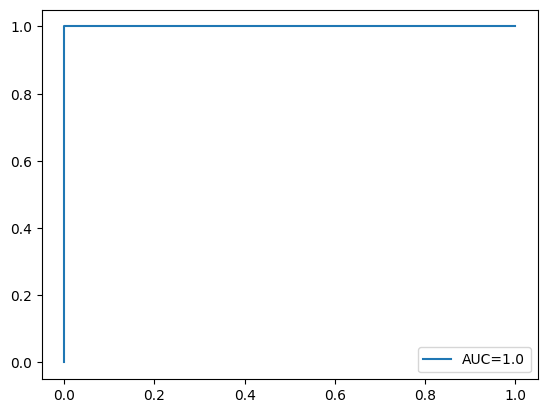

In [47]:
vis.draw_roc_curve_from_probabilities()

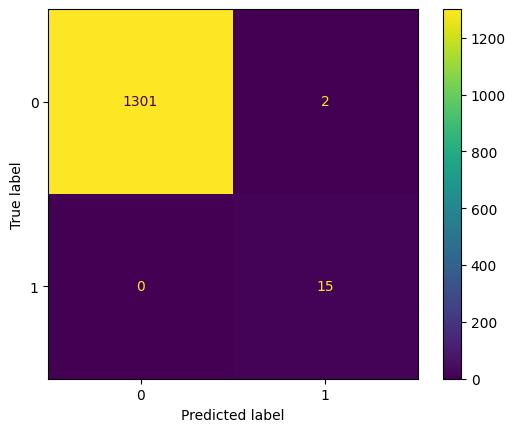

In [48]:
vis.display_confusion_matrix()